In [219]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from ifxAvian import Avian
from scipy import signal
import matplotlib.pyplot as plt
import csv
import joblib
import pandas as pd

print("Radar SDK Version: " + Avian.get_version())

RX1_data = []
RX2_data = []
RX3_data = []

Radar SDK Version: 3.4.0


In [220]:
def fft_spectrum(mat, range_window):
    # Calculate fft spectrum
    # mat:          chirp data
    # range_window: window applied on input data before fft

    # received data 'mat' is in matrix form for a single receive antenna
    # each row contains 'chirpsamples' samples for a single chirp
    # total number of rows = 'numchirps'

    # -------------------------------------------------
    # Step 1 - remove DC bias from samples
    # -------------------------------------------------
    [numchirps, chirpsamples] = np.shape(mat)

    # helpful in zero padding for high resolution FFT.
    # compute row (chirp) averages
    avgs = np.average(mat,1).reshape(numchirps,1)

    #de-bias values
    mat = mat - avgs
    # -------------------------------------------------
    # Step 2 - Windowing the Data
    # -------------------------------------------------
    mat = np.multiply(mat,range_window)

    # -------------------------------------------------
    # Step 3 - add zero padding here
    # -------------------------------------------------
    zp1 = np.pad(mat,((0,0),(0,chirpsamples)),'constant')

    # -------------------------------------------------
    # Step 4 - Compute FFT for distance information
    # -------------------------------------------------
    range_fft = np.fft.fft(zp1)/chirpsamples

    #ignore the redundant info in negative spectrum
    #compensate energy by doubling magnitude
    range_fft = 2*range_fft[:,range(int(chirpsamples))]

    return range_fft

In [221]:
def compute_doppler_map(data : np.ndarray, i_ant : int):
    mti_alpha = 0.8 # moving target indicator
    num_ant = 3
    mti_history = np.zeros((num_chirps_per_frame, num_samples_per_chirp, num_ant))
    """Compute Range-Doppler map for i-th antennas
    
    Parameter:
        - data:     Raw-data for one antenna (dimension:
                    num_chirps_per-frame x num_samples_per_chirp)
        - i_ant:    Number of antenna
    """
    # Step 1 - Remove average from signal (mean removal)
    data = data - np.average(data)

    # Step 2 - MTI processing to remove static objects
    data_mti = data - mti_history[:,:,i_ant]
    mti_history[:,:,i_ant] = data*mti_alpha + mti_history[:,:,i_ant]*(1-mti_alpha)

    # Step 3 - calculate fft spectrum for the frame
    fft1d = fft_spectrum(data_mti, range_window)

    # prepare for doppler FFT

    # Transpose
    # Distance is now indicated on y axis
    fft1d = np.transpose(fft1d)

    # Step 4 - Windowing the Data in doppler
    fft1d = np.multiply(fft1d,doppler_window)

    zp2 = np.pad(fft1d,((0,0),(0,num_chirps_per_frame)), "constant")
    fft2d = np.fft.fft(zp2)/num_chirps_per_frame

    # re-arrange fft result for zero speed at centre
    return np.fft.fftshift(fft2d,(1,))

In [222]:
class Draw:
    # Represents drawing for example
    #
    # Draw is done for each antenna, and each antenna is represented for
    # other subplot

    def __init__(self, max_speed_m_s, max_range_m, num_ant):
        # max_range_m:   maximum supported range
        # max_speed_m_s: maximum supported speed
        # num_ant:       Number of antennas
        self._h = []
        self._max_speed_m_s = max_speed_m_s
        self._max_range_m = max_range_m
        self._num_ant = num_ant

        self._fig, ax = plt.subplots(nrows=1, ncols=num_ant, figsize=((num_ant+1)//2,2))
        if(num_ant==1):
            self._ax = [ax]
        else:
            self._ax = ax

        self._fig.canvas.manager.set_window_title("Doppler")
        self._fig.set_size_inches(3*num_ant+1, 3+1/num_ant)
        self._fig.canvas.mpl_connect('close_event', self.close)
        self._is_window_open = True

    def _draw_first_time(self, data_all_antennas):
        # First time draw
        #
        # It computes minimal, maximum value and draw data for all antennas
        # in same scale
        # data_all_antennas: array of raw data for each antenna

        minmin = min([np.min(data) for data in data_all_antennas])
        maxmax = max([np.max(data) for data in data_all_antennas])

        for i_ant in range(self._num_ant):
            data = data_all_antennas[i_ant]
            h = self._ax[i_ant].imshow(
                        data,
                        vmin=minmin, vmax=maxmax,
                        cmap='jet',
                        extent=(    -self._max_speed_m_s,
                                    self._max_speed_m_s,
                                    0,
                                    self._max_range_m),
                        origin='lower')
            self._h.append(h)

            self._ax[i_ant].set_xlabel("velocity (m/s)")
            self._ax[i_ant].set_ylabel("distance (m)")
            self._ax[i_ant].set_title("antenna #"+str(i_ant))
        self._fig.subplots_adjust(right=0.8)
        cbar_ax = self._fig.add_axes([0.85, 0.0, 0.03, 1])

        cbar =self._fig.colorbar(self._h[0], cax=cbar_ax)
        cbar.ax.set_ylabel("magnitude (dB)")

    def _draw_next_time(self, data_all_antennas):
        # Update data for each antenna

        for i_ant in range(0, self._num_ant):
            data = data_all_antennas[i_ant]
            self._h[i_ant].set_data(data)

    def draw(self, data_all_antennas):
        # Draw data for all antenna
        if self._is_window_open:
            first_run = len(self._h) == 0
            if first_run:
                self._draw_first_time(data_all_antennas)
            else:
                self._draw_next_time(data_all_antennas)

            # Needed for Matplotlib ver: 3.4.0 and 3.4.1 helps with capture closing event
            plt.draw()
            plt.pause(1e-3)

    def close(self, event = None):
        if self.is_open():
            self._is_window_open = False
            plt.close(self._fig)
            plt.close('all')
            print('Application closed!')

    def is_open(self):
        return self._is_window_open
# -------------------------------------------------
# Helpers
# -------------------------------------------------
def parse_attr_nframes_frate( description, def_nframes, def_frate):
    # Parse all program attributes
    # description:   describes program
    # def_nframes:   default number of frames
    # def_frate:     default frame rate in Hz
    parser = argparse.ArgumentParser(
        description=description)

    parser.add_argument('-n', '--nframes', type=int,
                        default=def_nframes, help="number of frames, default "+str(def_nframes))
    parser.add_argument('-f', '--frate', type=int, default=def_frate,
                        help="frame rate in Hz, default "+str(def_frate))

    return parser.parse_args()

def linear_to_dB(x):
    return 20*np.log10(abs(x))

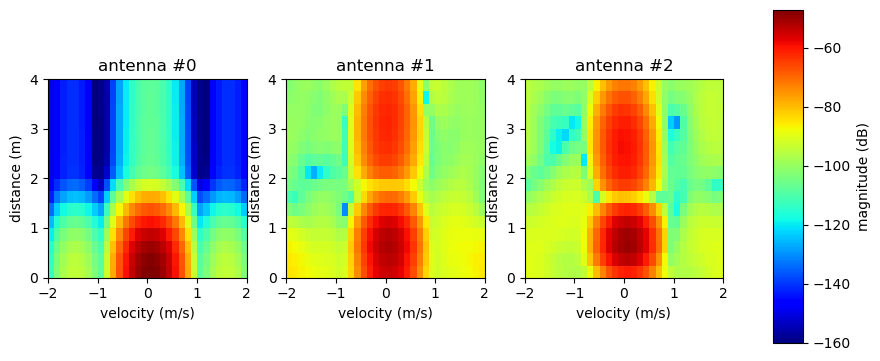

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Application closed!


In [223]:
with Avian.Device() as device:
    # set device config
    num_rx_antennas = device.get_sensor_information()["num_rx_antennas"]
    rx_mask = (1 << num_rx_antennas) - 1

    configR1 = Avian.DeviceConfig(
    sample_rate_Hz = 1_000_000,       # ADC sample rate of 1MHZ
    rx_mask = 7,                      # activate RX1 and RX3 AND RX2
    tx_mask = 1,                      # activate TX1
    if_gain_dB = 33,                  # gain of 33dB
    tx_power_level = 31,              # TX power level of 31
    start_frequency_Hz = 59.5e9,        #B=1.43GHz 
    end_frequency_Hz = 60.93e9,        
    num_chirps_per_frame = 16,       # 16 chirps per frame
    num_samples_per_chirp = 16,       # 64 samples per chirp
    chirp_repetition_time_s = 1240e-6, # 1240 us
    frame_repetition_time_s = 0.1,    # , frame_Rate = 25Hz
    hp_cutoff_Hz = 45_000,            # 80kHz cutoff frequency for high-pass filter
    aaf_cutoff_Hz = 500_000,          # Anti-aliasing cutoff frequency of 500kHz
    mimo_mode = 'off'                 # MIMO disabled
    )
    
    max_range_m =              4 # for graph only
    max_speed_m_s =            2 # for graph only


    device.set_config(configR1)
    num_chirps_per_frame = configR1.num_chirps_per_frame
    num_samples_per_chirp = configR1.num_samples_per_chirp
    range_window = signal.blackmanharris(num_samples_per_chirp).reshape(1,num_samples_per_chirp)
    doppler_window = signal.blackmanharris(num_chirps_per_frame).reshape(1,num_chirps_per_frame)
    draw = Draw(
        max_speed_m_s, \
        max_range_m, \
        num_rx_antennas)

    no_of_frames = 10 # recording for 1 second
    
    for frame_number in range(no_of_frames): # For each frame
        if not draw.is_open():
            break

        frame_data = device.get_next_frame()
        RX1_data.append(frame_data[0])
        RX2_data.append(frame_data[1])
        RX3_data.append(frame_data[2])

        data_all_antennas = []
        data_for_range_all = []



        for i_ant in range(0, num_rx_antennas): #For each antenna
            mat = frame_data[i_ant, :, :]
            data_for_range = compute_doppler_map(mat, i_ant)
            data_for_range_all.append(data_for_range)
            dfft_dbfs = linear_to_dB(data_for_range)
            data_all_antennas.append(dfft_dbfs)
        draw.draw(data_all_antennas);

    draw.close();

In [224]:
doppRX1 = []
doppRX2 = []
doppRX3 = []
dopp_all_antennas = []

for i_ant in range(0, num_rx_antennas): #For each antenna
    mat = frame_data[i_ant, :, :]
    dfft_dbfs = linear_to_dB(compute_doppler_map(mat, i_ant))
    dopp_all_antennas.append(dfft_dbfs)
    if i_ant==0:
        doppRX1.append(dfft_dbfs)
    if i_ant==1:
        doppRX2.append(dfft_dbfs)
    if i_ant==2:
        doppRX3.append(dfft_dbfs)


In [225]:
### getting linear value of range doppler

data_for_range = np.ndarray.flatten(data_for_range)
len(data_for_range_all)
rangeR1 = data_for_range_all[0]
rangeR2 = data_for_range_all[1]
rangeR3 = data_for_range_all[2]


In [226]:
# data = []
# data.append(np.ndarray.flatten(doppRX1[0]))
# data.append(np.ndarray.flatten(doppRX2[0]))
# data.append(np.ndarray.flatten(doppRX3[0]))
# data = np.array(data)
# data = np.ndarray.flatten(data)
# data = np.float16(data)

#### for range doppler data (absolute) ###

data = []
comp_data = []

data.append(np.ndarray.flatten(rangeR1))
data.append(np.ndarray.flatten(rangeR2))
data.append(np.ndarray.flatten(rangeR3))
data = np.array(data)
data = np.ndarray.flatten(data)

real_data = np.real(data)
img_data = np.imag(data)

comp_data.append(real_data)
comp_data.append(img_data)

comp_data = np.array(comp_data)
comp_data = np.ndarray.flatten(comp_data)
# data = np.float16(data)


In [227]:
# label = "LEFT"
# Columns = []
# for i in range(len(data-1)):
#     s = "Sample " + str(i)
#     Columns.append(s)
# Columns.append('GESTURE')

# data = data.astype(object)
# data = np.append(data,label)

label = "RIGHT"
Columns = []

## for real values
for i in range(1,len(np.ndarray.flatten(rangeR1))+1):
    s = "RX1 (" + str(i) + ") R"
    Columns.append(s)
    
for i in range(1,len(np.ndarray.flatten(rangeR2))+1):
    s = "RX2 (" + str(i) + ") R"
    Columns.append(s) 
    
for i in range(1,len(np.ndarray.flatten(rangeR3))+1):
    s = "RX3 (" + str(i) + ") R"
    Columns.append(s)

    
## for imaginary values
for i in range(1,len(np.ndarray.flatten(rangeR1))+1):
    s = "RX1 (" + str(i) + ") I"
    Columns.append(s)
    
for i in range(1,len(np.ndarray.flatten(rangeR2))+1):
    s = "RX2 (" + str(i) + ") I"
    Columns.append(s) 
    
for i in range(1,len(np.ndarray.flatten(rangeR3))+1):
    s = "RX3 (" + str(i) + ") I"
    Columns.append(s)
    
Columns.append('GESTURE')

# data = data.astype(object)
# data = np.append(data,label)

comp_data = comp_data.astype(object)
comp_data = np.append(comp_data,label)

In [228]:
with open('datasetT.csv', 'w', newline='') as file:
    # Create a writer object
    writer = csv.writer(file)

    # Write a column header to the CSV file
    writer.writerow(Columns)

In [229]:
with open('datasetT.csv', 'a', newline='') as file:
    # Create a writer object
    writer = csv.writer(file)

    # Writing data to the CSV file
    writer.writerow(comp_data)

In [230]:
#checking for naive bayes

model = joblib.load('demo_left_not.pkl')  # Load the saved model file
df1 = pd.read_csv('datasetT.csv')
newdata = df1.drop('GESTURE', axis=1)
newdata
p = model.predict(newdata)
p[0]

'RIGHT'

In [231]:
# # checking for LSTM

# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('lstm_model1.h5')
# df1 = pd.read_csv('datasetT.csv')
# newdata = df1.drop('GESTURE', axis=1)

# num_samples, input_dim = newdata.shape

# # Reshape the data to match the expected input shape
# newdata = newdata.values.reshape(num_samples, 1, input_dim)

# p = model.predict(newdata)
# p[0][0]
# # predicted_labels = np.argmax(p, axis=1)
# # print(predicted_labels[0])

In [232]:
# # LSTM 2
# # Load the saved model
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import LabelEncoder
# import tensorflow as tf

# # Load the dataset from a CSV file
# df = pd.read_csv('dataset.csv')

# # Separate the features and labels
# X = df.iloc[:, :-1].values
# y = df.iloc[:, -1].values

# # Convert the labels to numeric representation using LabelEncoder
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)


# # model = load_model('lstm_model1.h5')
# model = tf.keras.models.load_model('lstm_model1.h5')
# df1 = pd.read_csv('datasetT.csv')
# new_data = df1.drop('GESTURE', axis=1)

# # Prepare new data instance for prediction
# new_data = new_data.values.reshape(1, 1, 3072)

# # Make predictions on the new data instance
# predictions = model.predict(new_data)
# predicted_class = np.argmax(predictions)

# # Decode the predicted class using LabelEncoder
# predicted_class = label_encoder.inverse_transform([predicted_class])

# print("Predicted Class:", predicted_class[0])
